# Evaluation of the effectiveness of sgTuitions' Publicity using Bayesian Statistics

**Background**

[sgTuitions](https://t.me/sgTuitions) is a Telegram channel which matches tutors to tuition assignments. On 7 May 2019, [VulcanPost](https://vulcanpost.com/663190/telegram-channels-singapore-promo-codes-jobs/) (VP) posted an article featuring different Telegram channels and sgTuitions was one of it. [sgTuitionsBOT](https://t.me/sgTuitionsBOT) is a corresponding Telegram bot that allows users to apply for and post tuition assignments.

**Objective**

In this notebook, an attempt to evaluate the effectiveness of the article in boosting sgTuitionsBot usage. The method of evaluation relies on Bayesian statistics.

**Measure**

The measure chosen to evaluate its effectiveness is the average daily number of applications submitted (more information given below) to any assignments. This is to measure both the increased usage of the bot by a typical user and the increased number of users interacting with the bot. A Telegram ID can submit multiple applications.

Furthermore, assume that the priors for the average daily number of applications, before and after the VP post, are Poisson distributions with parameters $\lambda$ = $\lambda_1$, $\lambda_2$

In [59]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import datetime 
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import arviz
import os

plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 17
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.alpha'] = 0.5
mpl.rc('axes.spines',top=False,bottom=True,left=True,right=False)
plt.rcParams['savefig.dpi'] = 300

## Loading of data and some pre-processing

Make some subdirectories if they do not exist. They are for storing images and traces later.

In [68]:
if not os.path.isdir('images'):
    os.mkdir('images')
    
if not os.path.isdir('traces_dir'):
    os.mkdir('traces_dir')

To load the dataset.

In [41]:
daily_applications = pd.read_csv("sgT applications2019-2020.csv")

daily_applications['Timestamp'] = pd.to_datetime(daily_applications['Timestamp'])
daily_applications.set_index(['Timestamp'], inplace = True)

daily_applications = daily_applications['Telegram ID']

In [42]:
VP_datetime = "2019-05-07 03:30:59"
VP_datetime = pd.to_datetime(VP_datetime)

daily_applications_before_VP = daily_applications.loc[:VP_datetime]
daily_applications_after_VP = daily_applications.loc[VP_datetime:]

# Data visualization

Scatter plot of the daily number of applications submitted before and after the VP post.

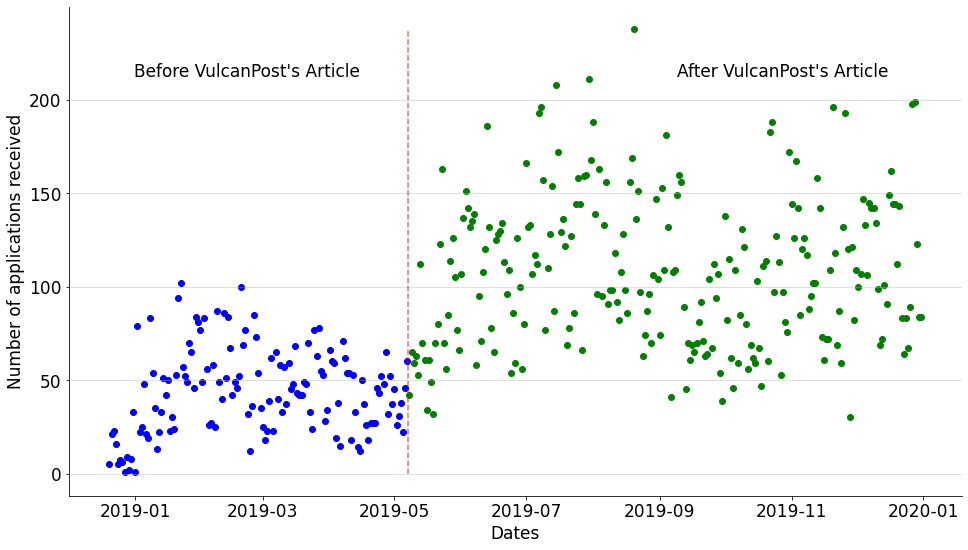

In [65]:
fig, ax = plt.subplots()
plt.scatter(daily_applications_before_VP.index, daily_applications_before_VP, color = 'b')
plt.scatter(daily_applications_after_VP.index, daily_applications_after_VP, color = 'g')

plt.vlines(VP_datetime, ymin = 0, ymax = daily_applications.max(), linestyles = '--', alpha = 0.6, color = 'r')

plt.text(0.2, 0.85, "Before VulcanPost's Article", horizontalalignment='center', va = 'bottom', transform = ax.transAxes)
plt.text(0.8, 0.85, "After VulcanPost's Article", horizontalalignment='center', va = 'bottom', transform = ax.transAxes)

plt.xlabel('Dates')
plt.ylabel('Number of applications received')

dir_name_images = os.path.join('.', 'images')
filename = os.path.join(dir_name_images, 'pre_analysis.png')
plt.savefig(filename)

Setting up of the model.

In [48]:
with pm.Model() as model:
    ### Each lambda of the resultant Poisson distributions are modeled with a prior exponential distribution with
    # different hyperparameters, alpha.
    alphas = 1.0/np.array([daily_applications_before_VP.mean(), daily_applications_after_VP.mean()])
    lambdas = pm.Exponential("lambdas", lam = alphas, shape = 2)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(daily_applications) - 1)

In [49]:
with model:
    idx = np.arange(len(daily_applications)) # Index
    lambda_ = pm.math.switch(tau > idx, lambdas[0], lambdas[1])

In [50]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=daily_applications)

In [52]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=500,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambdas]


Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 1052 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


# Save the traces and plot it

In [60]:
dir_name = os.path.join('.', 'traces_dir')
pm.save_trace(trace = trace, directory = dir_name, overwrite = True)

'.\\traces_dir'

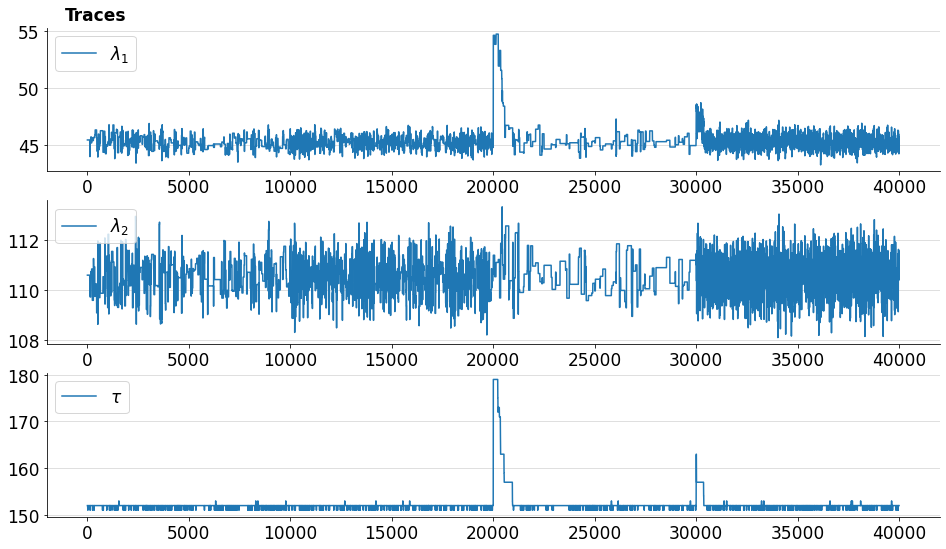

In [75]:
fig, axes = plt.subplots(3,1)
ax = axes.flat

ax[0].plot(trace['lambdas'][:,0], label = '$\lambda_1$')
ax[0].legend(loc = 'upper left')
ax[1].plot(trace['lambdas'][:,1], label = '$\lambda_2$')
ax[1].legend(loc = 'upper left')
ax[2].plot(trace['tau'], label = '$\\tau$')
ax[2].legend(loc = 'upper left')
ax[0].text(0.02, 1.05, "Traces", fontweight = 'heavy', transform = ax[0].transAxes)

dir_name_images = os.path.join('.', 'images')
filename = os.path.join(dir_name_images, 'samples_draws_from_dists.png')
plt.savefig(filename)

# Plotting of the posterior distributions of $\lambda_1$ and $\lambda_2$

IndexError: index 2 is out of bounds for axis 0 with size 2

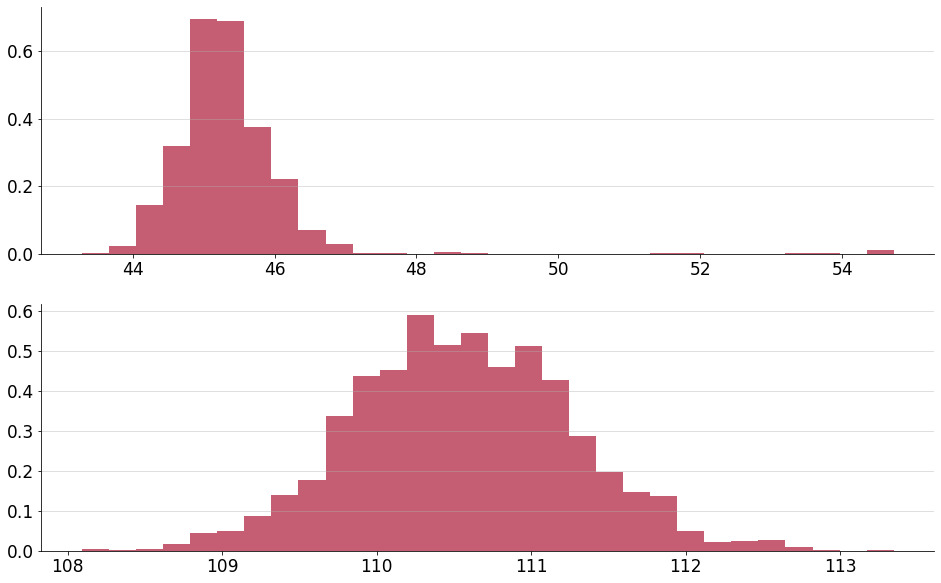

In [92]:
fig, axes = plt.subplots(2,1, figsize = (16,10))
ax = axes.flat

lambda_1_samples = trace['lambdas'][:,0]
lambda_2_samples = trace['lambdas'][:,1]
tau_samples = trace['tau']

ax[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.65,
         label="posterior of $\lambda_1$", color="#A60628", density = True)

ax[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.65,
         label="posterior of $\lambda_2$", color="#A60628", density = True)

for i, a in enumerate(ax):
    a.text(0.05, 0.98, f"Posterior of $\lambda_{i}$", transform = a.transAxes, fontsize = 20)
    a.set_xlabel(f'$\lambda_{i}$')
    a.set_ylabel('Density')
    
dir_name_images = os.path.join('.', 'images')
filename = os.path.join(dir_name_images, 'posterior_dists.png')
plt.savefig(filename)

(array([3.8679e+04, 1.4000e+01, 7.6400e+02, 4.0000e+00, 1.8000e+02,
        7.0000e+00, 3.0000e+00, 1.1700e+02, 1.1000e+01, 2.2100e+02]),
 array([151. , 153.8, 156.6, 159.4, 162.2, 165. , 167.8, 170.6, 173.4,
        176.2, 179. ]),
 <a list of 10 Patch objects>)

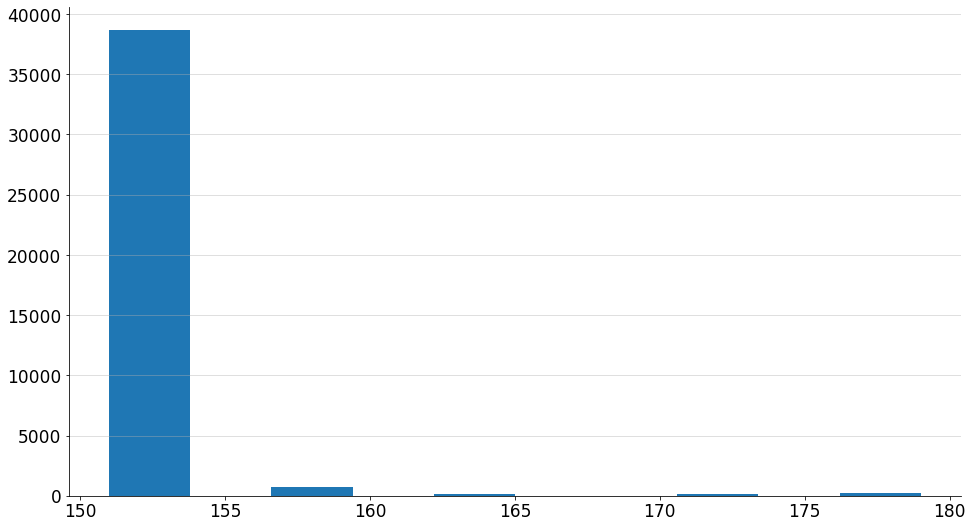

In [94]:
plt.hist(tau_samples)

# Calculation of the expected daily number of applications

In [89]:
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(len(daily_applications))

for day in range(0, len(daily_applications)):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

# Plotting of the expected daily number of applications imposed on the original scatter plot

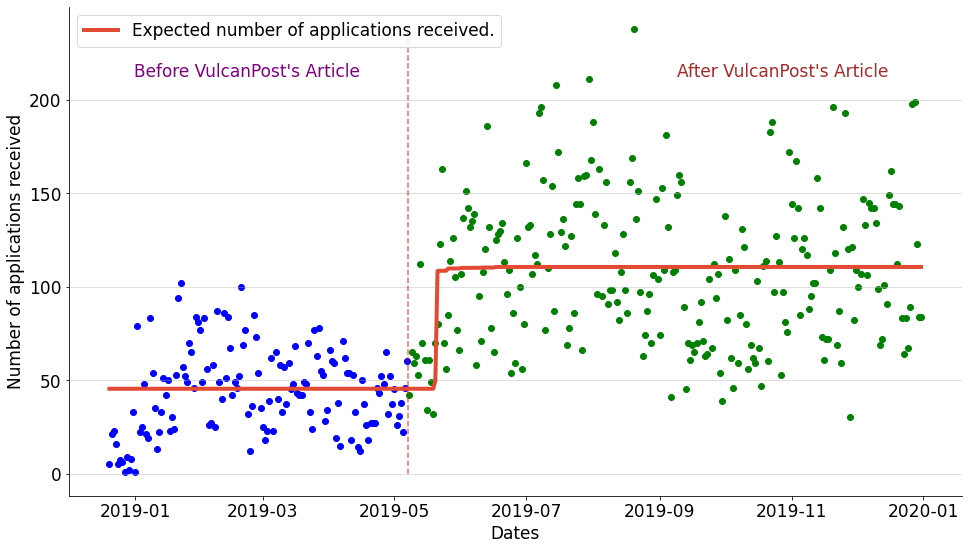

In [90]:
fig, ax = plt.subplots()
plt.scatter(daily_applications_before_VP.index, daily_applications_before_VP, color = 'b')
plt.scatter(daily_applications_after_VP.index, daily_applications_after_VP, color = 'g')

plt.vlines(VP_datetime, ymin = 0, ymax = daily_applications.max(), linestyles = '--', alpha = 0.6, color = 'r')

plt.text(0.2, 0.85, "Before VulcanPost's Article", horizontalalignment='center', va = 'bottom',
         transform = ax.transAxes, color = 'purple')
plt.text(0.8, 0.85, "After VulcanPost's Article", horizontalalignment='center', va = 'bottom',
         transform = ax.transAxes, color = 'brown')

plt.plot(daily_applications.index, expected_texts_per_day, lw=4, color="#E24A33",
         label="Expected number of applications received.")

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Number of applications received')

dir_name_images = os.path.join('.', 'images')
filename = os.path.join(dir_name_images, 'post_analysis.png')
plt.savefig(filename)

# Calculate the probability that $\lambda_1$ > $\lambda_2$

In [88]:
np.mean(trace['lambdas'][:,0] > trace['lambdas'][:,1])/len(trace['lambdas'][:,0])

0.0

# Conclusion

Calculation of the probability such that the average rate of applications before the VP post is less than that after the VP post is done and it reveals that it is virtually impossible that the rate is higher before the VP post.

Therefore, it is clear that the VP post was indeed effectiveness in promoting more applications to tuition assignments.

# References

This notebook took reference heavily from the work by Cameron Davidson-Pilon ([Github](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC3.ipynb)).

[1] Probabilistic Programming and Bayesian Methods for Hackers. Chapter 1. https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb